In [15]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [19]:
import tensorflow as tf
tf.test.gpu_device_name()

''

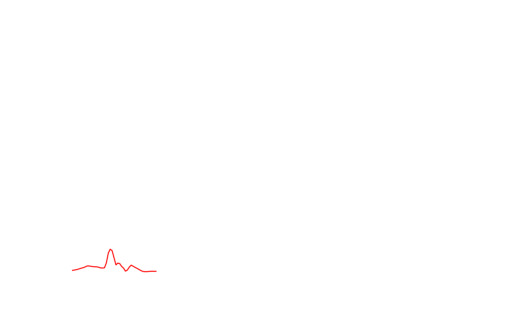

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pil_im = Image.open('C:/Users/anam0/Desktop/TFT/Codigo/DatasetFemaleOrganizado/12_15/Neurodivergente/491980_14_F/Aceleracion - D_H_586629_L_child__1_68_LPM_2024_02_22_13_40_24_T1_1.csv.png', 'r')
plt.imshow(np.asarray(pil_im))
plt.axis('off') 
plt.show()


In [65]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

def create_and_clear_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

source_dir = "C:/Users/anam0/Desktop/TFT/Codigo/DatasetFemaleOrganizado/12_15"
train_dir = "C:/Users/anam0/Desktop/TFT/Codigo/DatasetFemaleOrganizado/12_15_Train"
val_dir = "C:/Users/anam0/Desktop/TFT/Codigo/DatasetFemaleOrganizado/12_15_Val"

create_and_clear_dir(train_dir)
create_and_clear_dir(val_dir)

class_names = os.listdir(source_dir)

for class_name in class_names:
    class_path = os.path.join(source_dir, class_name)
    directories = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]

    train_dirs, val_dirs = train_test_split(directories, test_size=0.3, random_state=np.random.randint(0, 10000))

    for d in train_dirs:
        shutil.copytree(os.path.join(class_path, d), os.path.join(train_dir, class_name, d))

    for d in val_dirs:
        shutil.copytree(os.path.join(class_path, d), os.path.join(val_dir, class_name, d))
class_names = os.listdir(source_dir)
print("Data reorganized into train and validation folders.")


Data reorganized into train and validation folders.


In [67]:
image_size = (600, 1000)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Verificar el número de ejemplos en cada conjunto
train_count = tf.data.experimental.cardinality(train_ds).numpy()
val_count = tf.data.experimental.cardinality(val_ds).numpy()

print(f"Number of training batches: {train_count}")
print(f"Number of validation batches: {val_count}")

# Verificar número de ejemplos por clase
train_class_counts = {class_name: 0 for class_name in class_names}
val_class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    for label in labels:
        class_index = np.argmax(label.numpy())
        class_name = class_names[class_index]
        train_class_counts[class_name] += 1

for images, labels in val_ds:
    for label in labels:
        class_index = np.argmax(label.numpy())
        class_name = class_names[class_index]
        val_class_counts[class_name] += 1

print(f"Training class counts: {train_class_counts}")
print(f"Validation class counts: {val_class_counts}")


Found 30 files belonging to 2 classes.
Found 15 files belonging to 2 classes.
Classes in the dataset: ['Neurodivergente', 'Neurotipico']
Number of training batches: 2
Number of validation batches: 1
Training class counts: {'Neurodivergente': 9, 'Neurotipico': 21}
Validation class counts: {'Neurodivergente': 6, 'Neurotipico': 9}


In [79]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./255),
                    offset=-1,
                    input_shape=(600, 1000, 3)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

C:\Users\anam0\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 600, 1000, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 598, 998, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 299, 499, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 297, 497, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 148, 248, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 148, 248, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 146, 246, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 73, 123, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 73, 123, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1149312)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │   147,112,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,205,570 (561.54 MB)

 Trainable params: 147,205,570 (561.54 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
#model.save('modelo6.h5')

In [83]:
# TRAINING --------------------------------------------------

epochs = 200
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)

h = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 14s/step - accuracy: 0.5431 - loss: 0.8901 - val_accuracy: 0.5333 - val_loss: 0.6953
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.5444 - loss: 0.5937 - val_accuracy: 0.6000 - val_loss: 0.6908
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.8042 - loss: 0.3406 - val_accuracy: 0.6000 - val_loss: 0.6883
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.8694 - loss: 0.3034 - val_accuracy: 0.6000 - val_loss: 0.6993
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.9347 - loss: 0.2085 - val_accuracy: 0.6000 - val_loss: 0.7559
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.9778 - loss: 0.1448 - val_accuracy: 0.6667 - val_loss: 0.8813
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.9778 - loss: 0.0810 - val_accuracy: 0.6000 - val_loss: 1.0678
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 1.0000 - loss: 0.0555 - val_accuracy: 0.6000 - val_loss: 1.3173

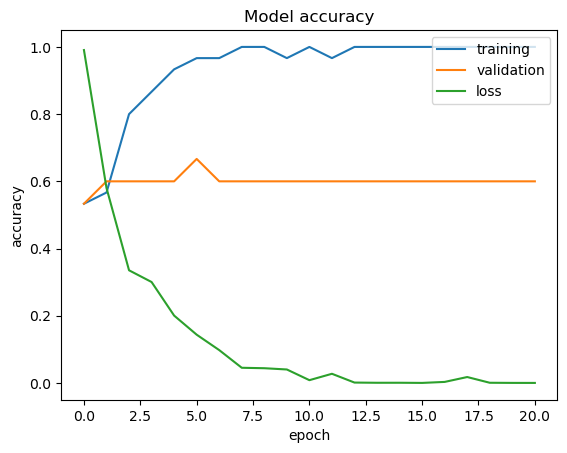

In [85]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


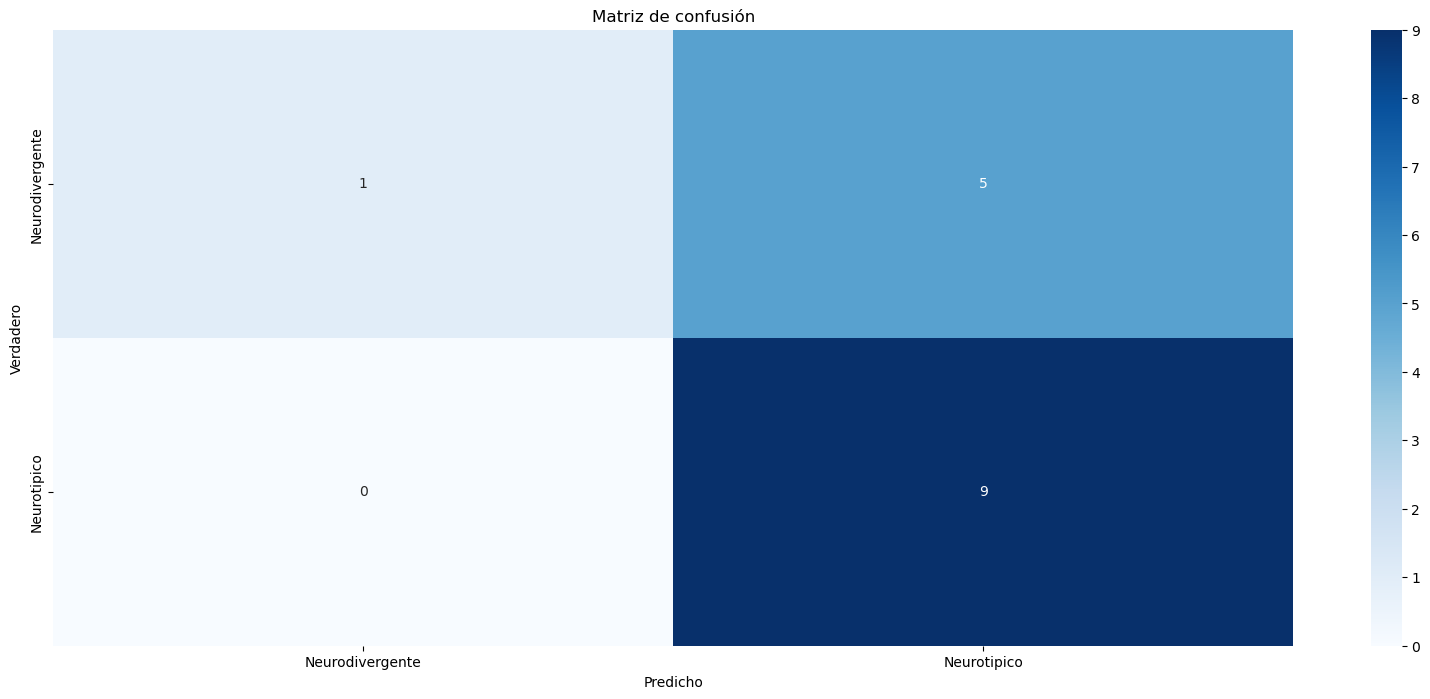

                 precision    recall  f1-score   support

Neurodivergente     1.0000    0.1667    0.2857         6
    Neurotipico     0.6429    1.0000    0.7826         9

       accuracy                         0.6667        15
      macro avg     0.8214    0.5833    0.5342        15
   weighted avg     0.7857    0.6667    0.5839        15



In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones y etiquetas reales
y_true = []
y_pred = []

for x, y in val_ds:
    predictions = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular la matriz de confusión
cf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(20, 8))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [89]:
img = keras.preprocessing.image.load_img(
    'C:/Users/anam0/Desktop/TFT/Codigo/DatasetFemaleOrganizado/Testeo_12_15_Neurodivergente/530539_12_F/Aceleracion - D_H_530539_L_child__1_89_LPM_2023_12_27_13_34_00_T1_1.csv.png', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1
